In [1]:
#importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np

# custom libraries for visulization
import scienceplots 
plt.style.use(['science', 'ieee', 'no-latex'])

## ⚙️ Physics-Informed Neural Networks (PINNs)

### 🧠 Motivation: Why PINNs?

Traditional numerical solvers for differential equations—such as finite difference or finite element methods—typically discretize the domain, approximate derivatives, and iteratively compute solutions with high precision. While effective for well-posed and well-understood systems, these methods have several limitations:

- Struggle with **noisy**, **incomplete**, or **sparse data**
- Inefficient for **high-dimensional** or **parameterized** systems
- Require **domain-specific tuning**
- Scale poorly with problem **complexity**
- Cannot easily incorporate **observational data** or perform **inverse problem solving**

**Physics-Informed Neural Networks (PINNs)** offer a modern, flexible alternative. Instead of discretizing the system, we approximate the solution with a **neural network**, trained to satisfy:

1. The governing **differential equation**
2. The **initial** and **boundary conditions**

Due to the **Universal Approximation Theorem**, a neural network with sufficient complexity can represent the solution arbitrarily well, provided the loss functions correctly enforce physical laws and constraints.

---

### ⚡ Improvements over Vanilla PINNs

While standard PINNs are powerful, they still suffer from challenges like multi-objective optimization, poor scaling, and difficulties in enforcing hard constraints. Several enhancements can improve their performance and stability:

#### 1. ✅ Hard-Coded Initial Conditions via Ansätze

Instead of adding initial conditions as separate loss terms, we design the **functional form (Ansatz)** of the neural network to satisfy them **by construction**. This eliminates the need for multi-objective optimization and guarantees physically valid solutions.

#### 2. 🔁 Rescaling the Domain

Since the solution domain is known in advance, we **rescale** the problem to a normalized domain, such as $ t \in [0, 1] $, via an invertible transformation. This has several benefits:
- Avoids extreme values in gradients
- Keeps the input range compact
- Stabilizes training and avoids vanishing/exploding gradients

#### 3. 🔗 Augmented Lagrangian for PDE Residuals

Instead of minimizing the ODE/PDE residual via soft penalty loss, we can use **Augmented Lagrangian methods** to enforce the physics constraints more strictly, reducing the risk of the network learning unphysical solutions.

---

## 🔄 Domain Rescaling

Consider the damped harmonic oscillator equation:

$$
\frac{d^{2}x}{dz^{2}} + 2\xi \frac{dx}{dz} + x = 0
$$

We rescale the independent variable:

$$
t = \frac{z}{20} \quad \Rightarrow \quad z = 20t
$$

Then, the derivatives transform as:

$$
\frac{d}{dz} = \frac{1}{20} \frac{d}{dt}, \quad \frac{d^2}{dz^2} = \frac{1}{20^2} \frac{d^2}{dt^2}
$$

Substituting into the original ODE:

$$
\frac{1}{400} \frac{d^2x}{dt^2} + \frac{2\xi}{20} \frac{dx}{dt} + x = 0
$$

Multiplying through by 400 to normalize:

$$
\frac{d^2x}{dt^2} + 40\xi \frac{dx}{dt} + 400x = 0
$$

This rescaling helps stabilize training by keeping the network's input domain compact, reducing gradient saturation, and enabling better convergence.

---

## 🧩 Enforcing Initial Conditions with Hard Constraints

Let:
- $ x_0 = 0.7 $ (initial position)
- $ v_0 = 1.2 $ (initial velocity)

Instead of treating these as soft constraints in the loss function, we encode them **directly into the solution Ansatz**:

$$
U(t) = x_0 + 20t \cdot v_0 + t^2 \cdot \text{NN}_\theta(t)
$$

Key observations:
- $ U(0) = x_0 $
- $ \frac{dU}{dt}(0) = 20 v_0 $, due to chain rule and rescaling

This guarantees the network satisfies initial conditions **exactly**, reducing training complexity and improving physical validity.

In [2]:
# Physics constants
x0, v0 = 0.7, 1.2
xi = 0.1

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# FC Neural Network
class FCNet(nn.Module):
    def __init__(self, hidden_dim=64, num_layers=4):
        super().__init__()
        layers = [nn.Linear(1, hidden_dim), nn.Tanh()]
        for _ in range(num_layers - 2):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers += [nn.Linear(hidden_dim, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, t):
        return self.net(t)

# Hard-constrained PINN via Ansatz
class PINN(nn.Module):
    def __init__(self, base_net):
        super().__init__()
        self.f_theta = base_net

    def forward(self, t):
        return x0 + 20 * t * v0 + t ** 2 * self.f_theta(t)

# DataParallel support
def make_parallel(model):
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)
    return model.to(device)

# PDE residual
def residual_loss(model, t):
    t.requires_grad_(True)
    x = model(t)
    dx = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    d2x = torch.autograd.grad(dx, t, grad_outputs=torch.ones_like(dx), create_graph=True)[0]
    res = d2x + 40 * xi * dx + 400 * x
    return torch.mean(res ** 2)

# Classical numerical solution
def classical_solution(z_eval):
    def f(z, y):
        x, dx = y
        return [dx, -2 * xi * dx - x]
    sol = solve_ivp(f, [0, 20], [x0, v0], t_eval=z_eval)
    return sol.t, sol.y[0]


In [4]:
# Setup
torch.manual_seed(0)
base_net = FCNet()
model = PINN(base_net).to(device)

# Training data
t_train = torch.linspace(0, 1, 1000).view(-1, 1).to(device)

# L-BFGS
optimizer = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn="strong_wolfe")

iteration = [0]
def closure():
    optimizer.zero_grad()
    loss = residual_loss(model, t_train)
    loss.backward()
    if iteration[0] % 20 == 0:
        print(f"[L-BFGS] Iter {iteration[0]}: Loss = {loss.item():.3e}")
    iteration[0] += 1
    return loss

# Train
print("Starting L-BFGS training...")
optimizer.step(closure)
print("Training complete ✅")

Starting L-BFGS training...
[L-BFGS] Iter 0: Loss = 3.438e+07
[L-BFGS] Iter 20: Loss = 1.556e+05
[L-BFGS] Iter 40: Loss = 4.315e+04
[L-BFGS] Iter 60: Loss = 1.209e+04
[L-BFGS] Iter 80: Loss = 5.078e+03
[L-BFGS] Iter 100: Loss = 1.990e+03
[L-BFGS] Iter 120: Loss = 7.926e+02
[L-BFGS] Iter 140: Loss = 2.992e+02
[L-BFGS] Iter 160: Loss = 2.265e+02
[L-BFGS] Iter 180: Loss = 1.472e+02
[L-BFGS] Iter 200: Loss = 1.406e+02
[L-BFGS] Iter 220: Loss = 1.334e+02
[L-BFGS] Iter 240: Loss = 1.295e+02
[L-BFGS] Iter 260: Loss = 1.272e+02
[L-BFGS] Iter 280: Loss = 1.254e+02
[L-BFGS] Iter 300: Loss = 1.223e+02
[L-BFGS] Iter 320: Loss = 1.211e+02
[L-BFGS] Iter 340: Loss = 1.197e+02
[L-BFGS] Iter 360: Loss = 1.188e+02
[L-BFGS] Iter 380: Loss = 1.184e+02
[L-BFGS] Iter 400: Loss = 1.176e+02
[L-BFGS] Iter 420: Loss = 1.173e+02
[L-BFGS] Iter 440: Loss = 1.171e+02
[L-BFGS] Iter 460: Loss = 1.163e+02
[L-BFGS] Iter 480: Loss = 1.158e+02
[L-BFGS] Iter 500: Loss = 1.160e+02
[L-BFGS] Iter 520: Loss = 1.139e+02
[L-BFG

In [5]:
# Evaluate model
t_test = torch.linspace(0, 1, 300).view(-1, 1).to(device)
with torch.no_grad():
    x_pinn = model(t_test).cpu().numpy()
    z_test = (20 * t_test).cpu().numpy().flatten()

# Classical
z_classic, x_classic = classical_solution(z_test)
abs_error = np.abs(x_pinn.flatten() - x_classic)

# Residual eval
t_resid = torch.tensor(z_test / 20, dtype=torch.float32).view(-1, 1).to(device)
t_resid.requires_grad = True

# disables autograd and t_resid doesn’t track gradients
#with torch.no_grad(): 
x_pred = model(t_resid)
dx = torch.autograd.grad(x_pred, t_resid, torch.ones_like(x_pred), create_graph=True)[0]
d2x = torch.autograd.grad(dx, t_resid, torch.ones_like(dx), create_graph=True)[0]
resid = (d2x + 40 * xi * dx + 400 * x_pred).detach().cpu().numpy().flatten()


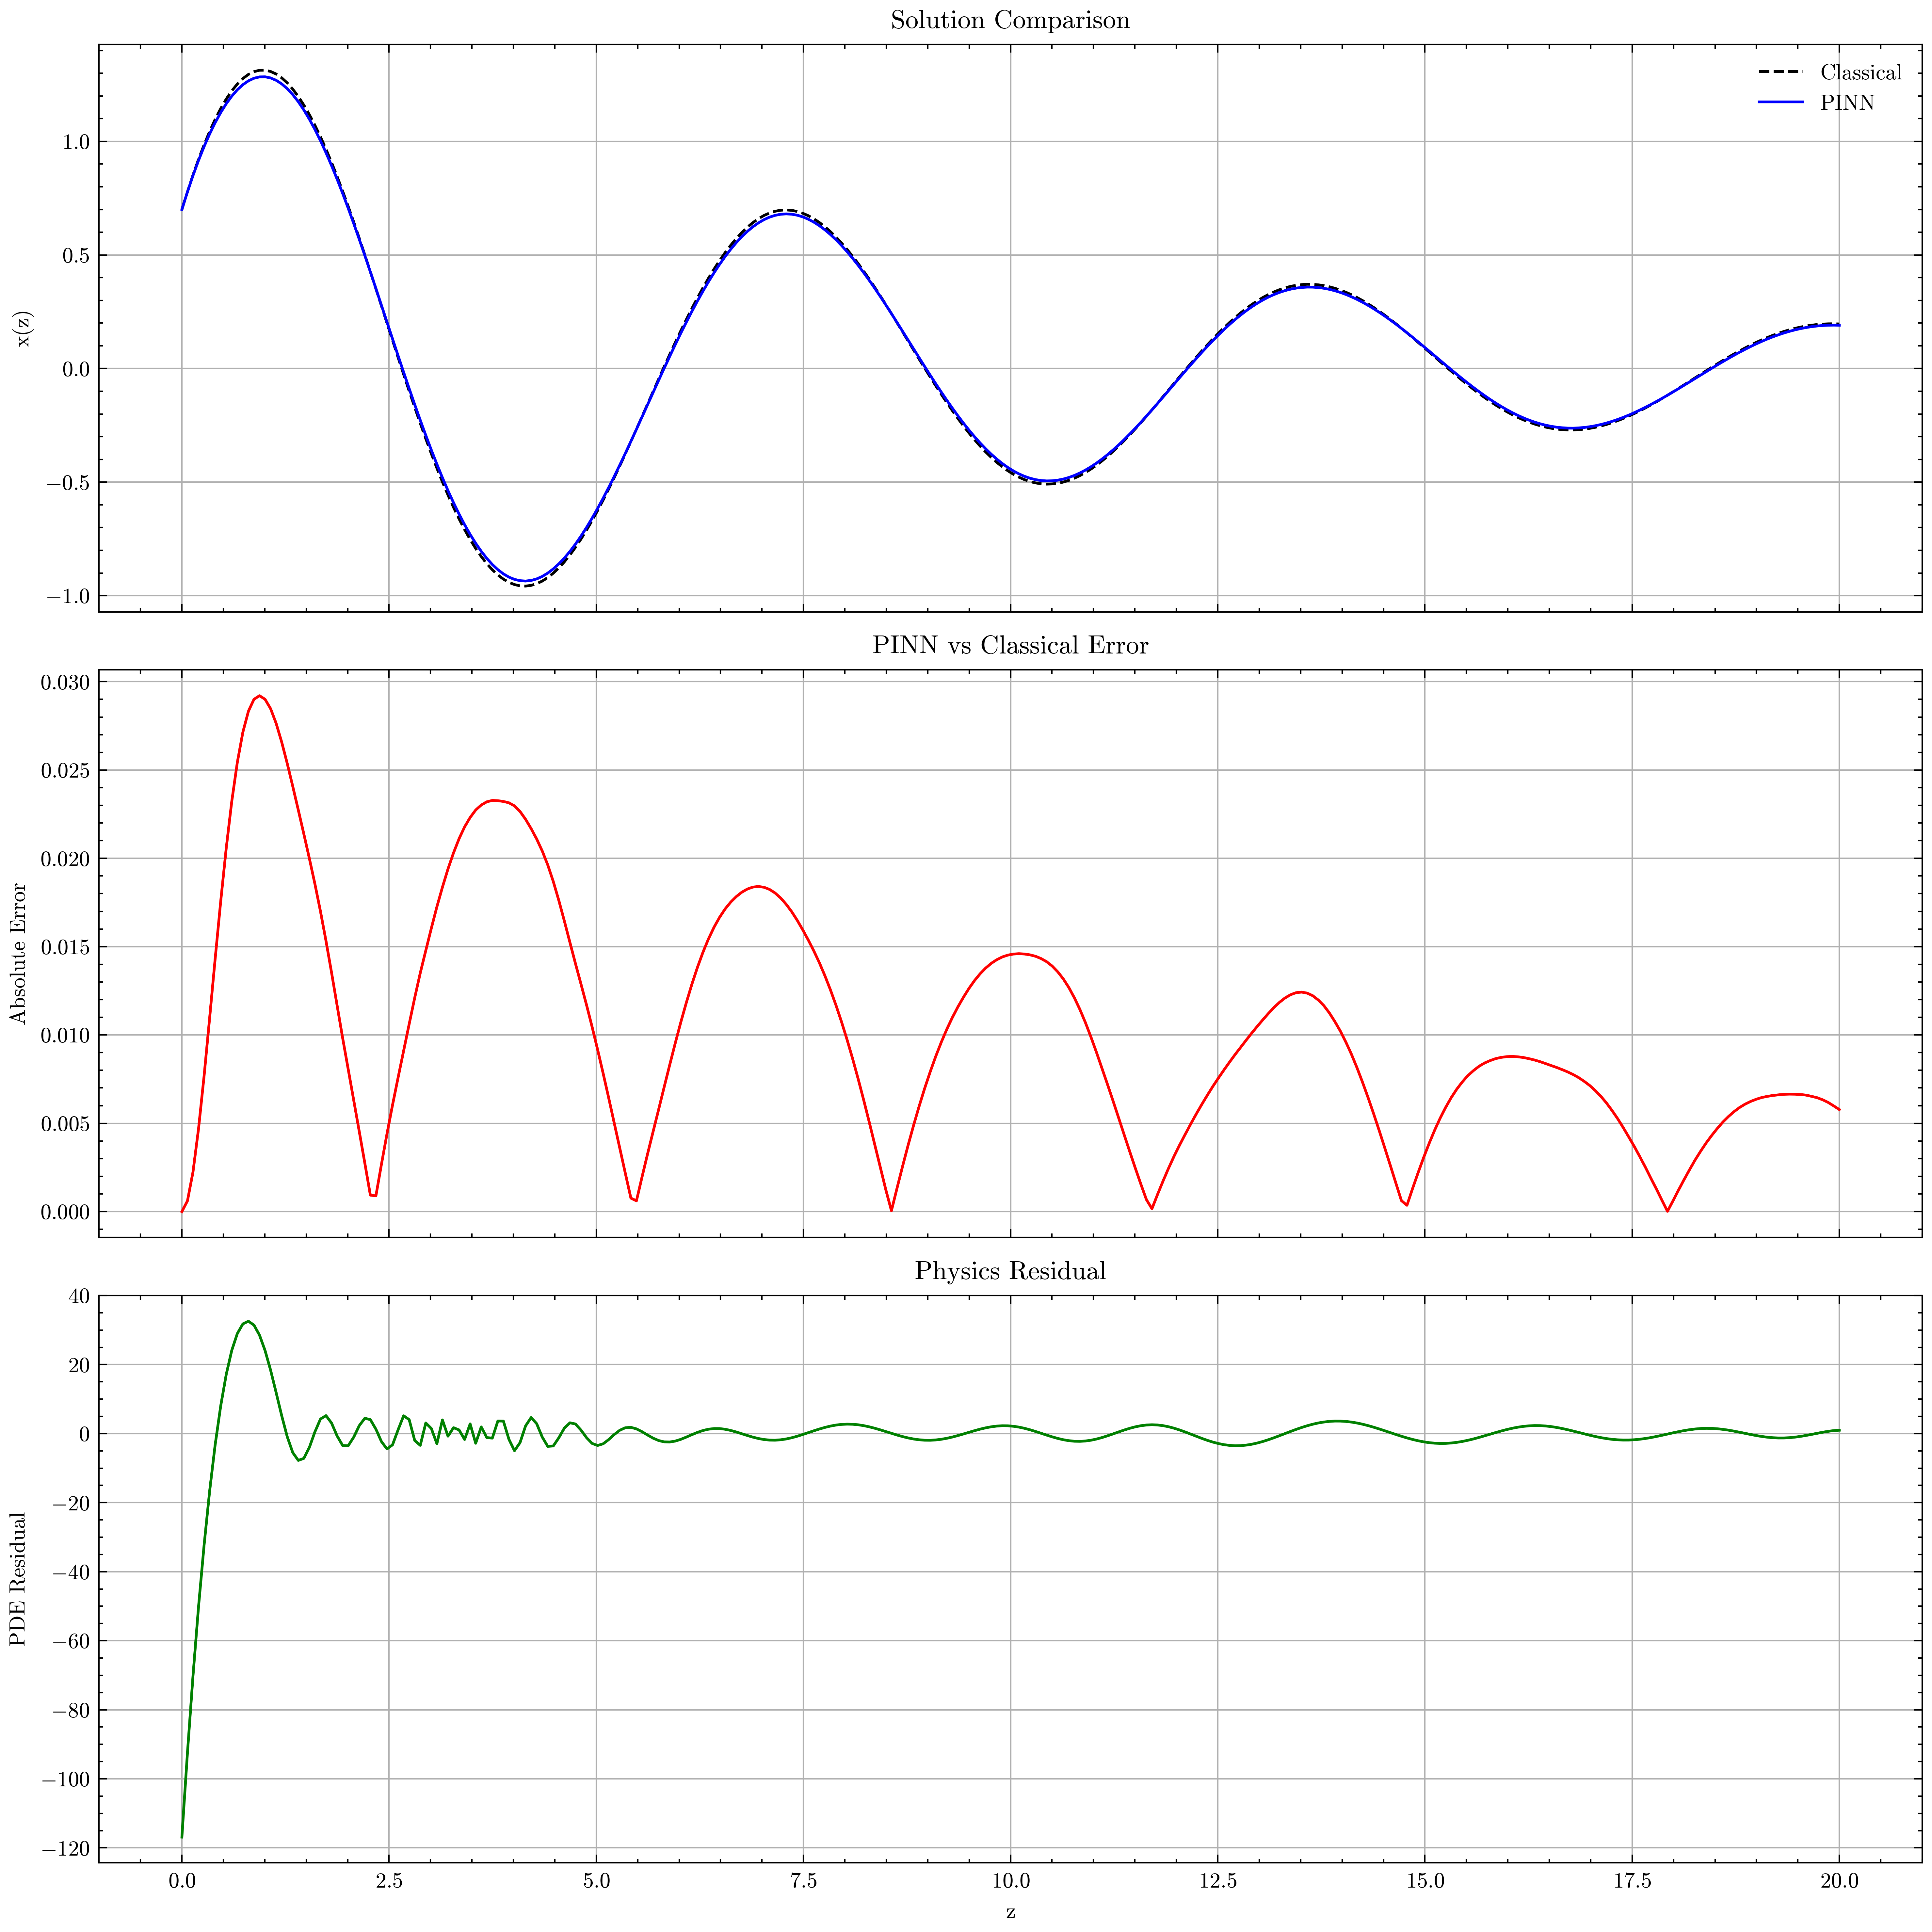

In [6]:

# Visualization
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

axs[0].plot(z_test, x_classic, 'k--', label='Classical')
axs[0].plot(z_test, x_pinn, 'b', label='PINN')
axs[0].set_ylabel("x(z)")
axs[0].set_title("Solution Comparison")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(z_test, abs_error, 'r')
axs[1].set_ylabel("Absolute Error")
axs[1].set_title("PINN vs Classical Error")
axs[1].grid(True)

axs[2].plot(z_test, resid, 'g')
axs[2].set_ylabel("PDE Residual")
axs[2].set_xlabel("z")
axs[2].set_title("Physics Residual")
axs[2].grid(True)

plt.tight_layout()
plt.savefig('ivp_vs_pinn_solution.png', dpi=300, bbox_inches='tight')
plt.show()


## 🔍 1. **Phase Space Plot** — \( x \) vs \( \dot{x} \)

**Why:** Shows the system's dynamics — lets you compare learned and exact trajectories in a physically meaningful way.

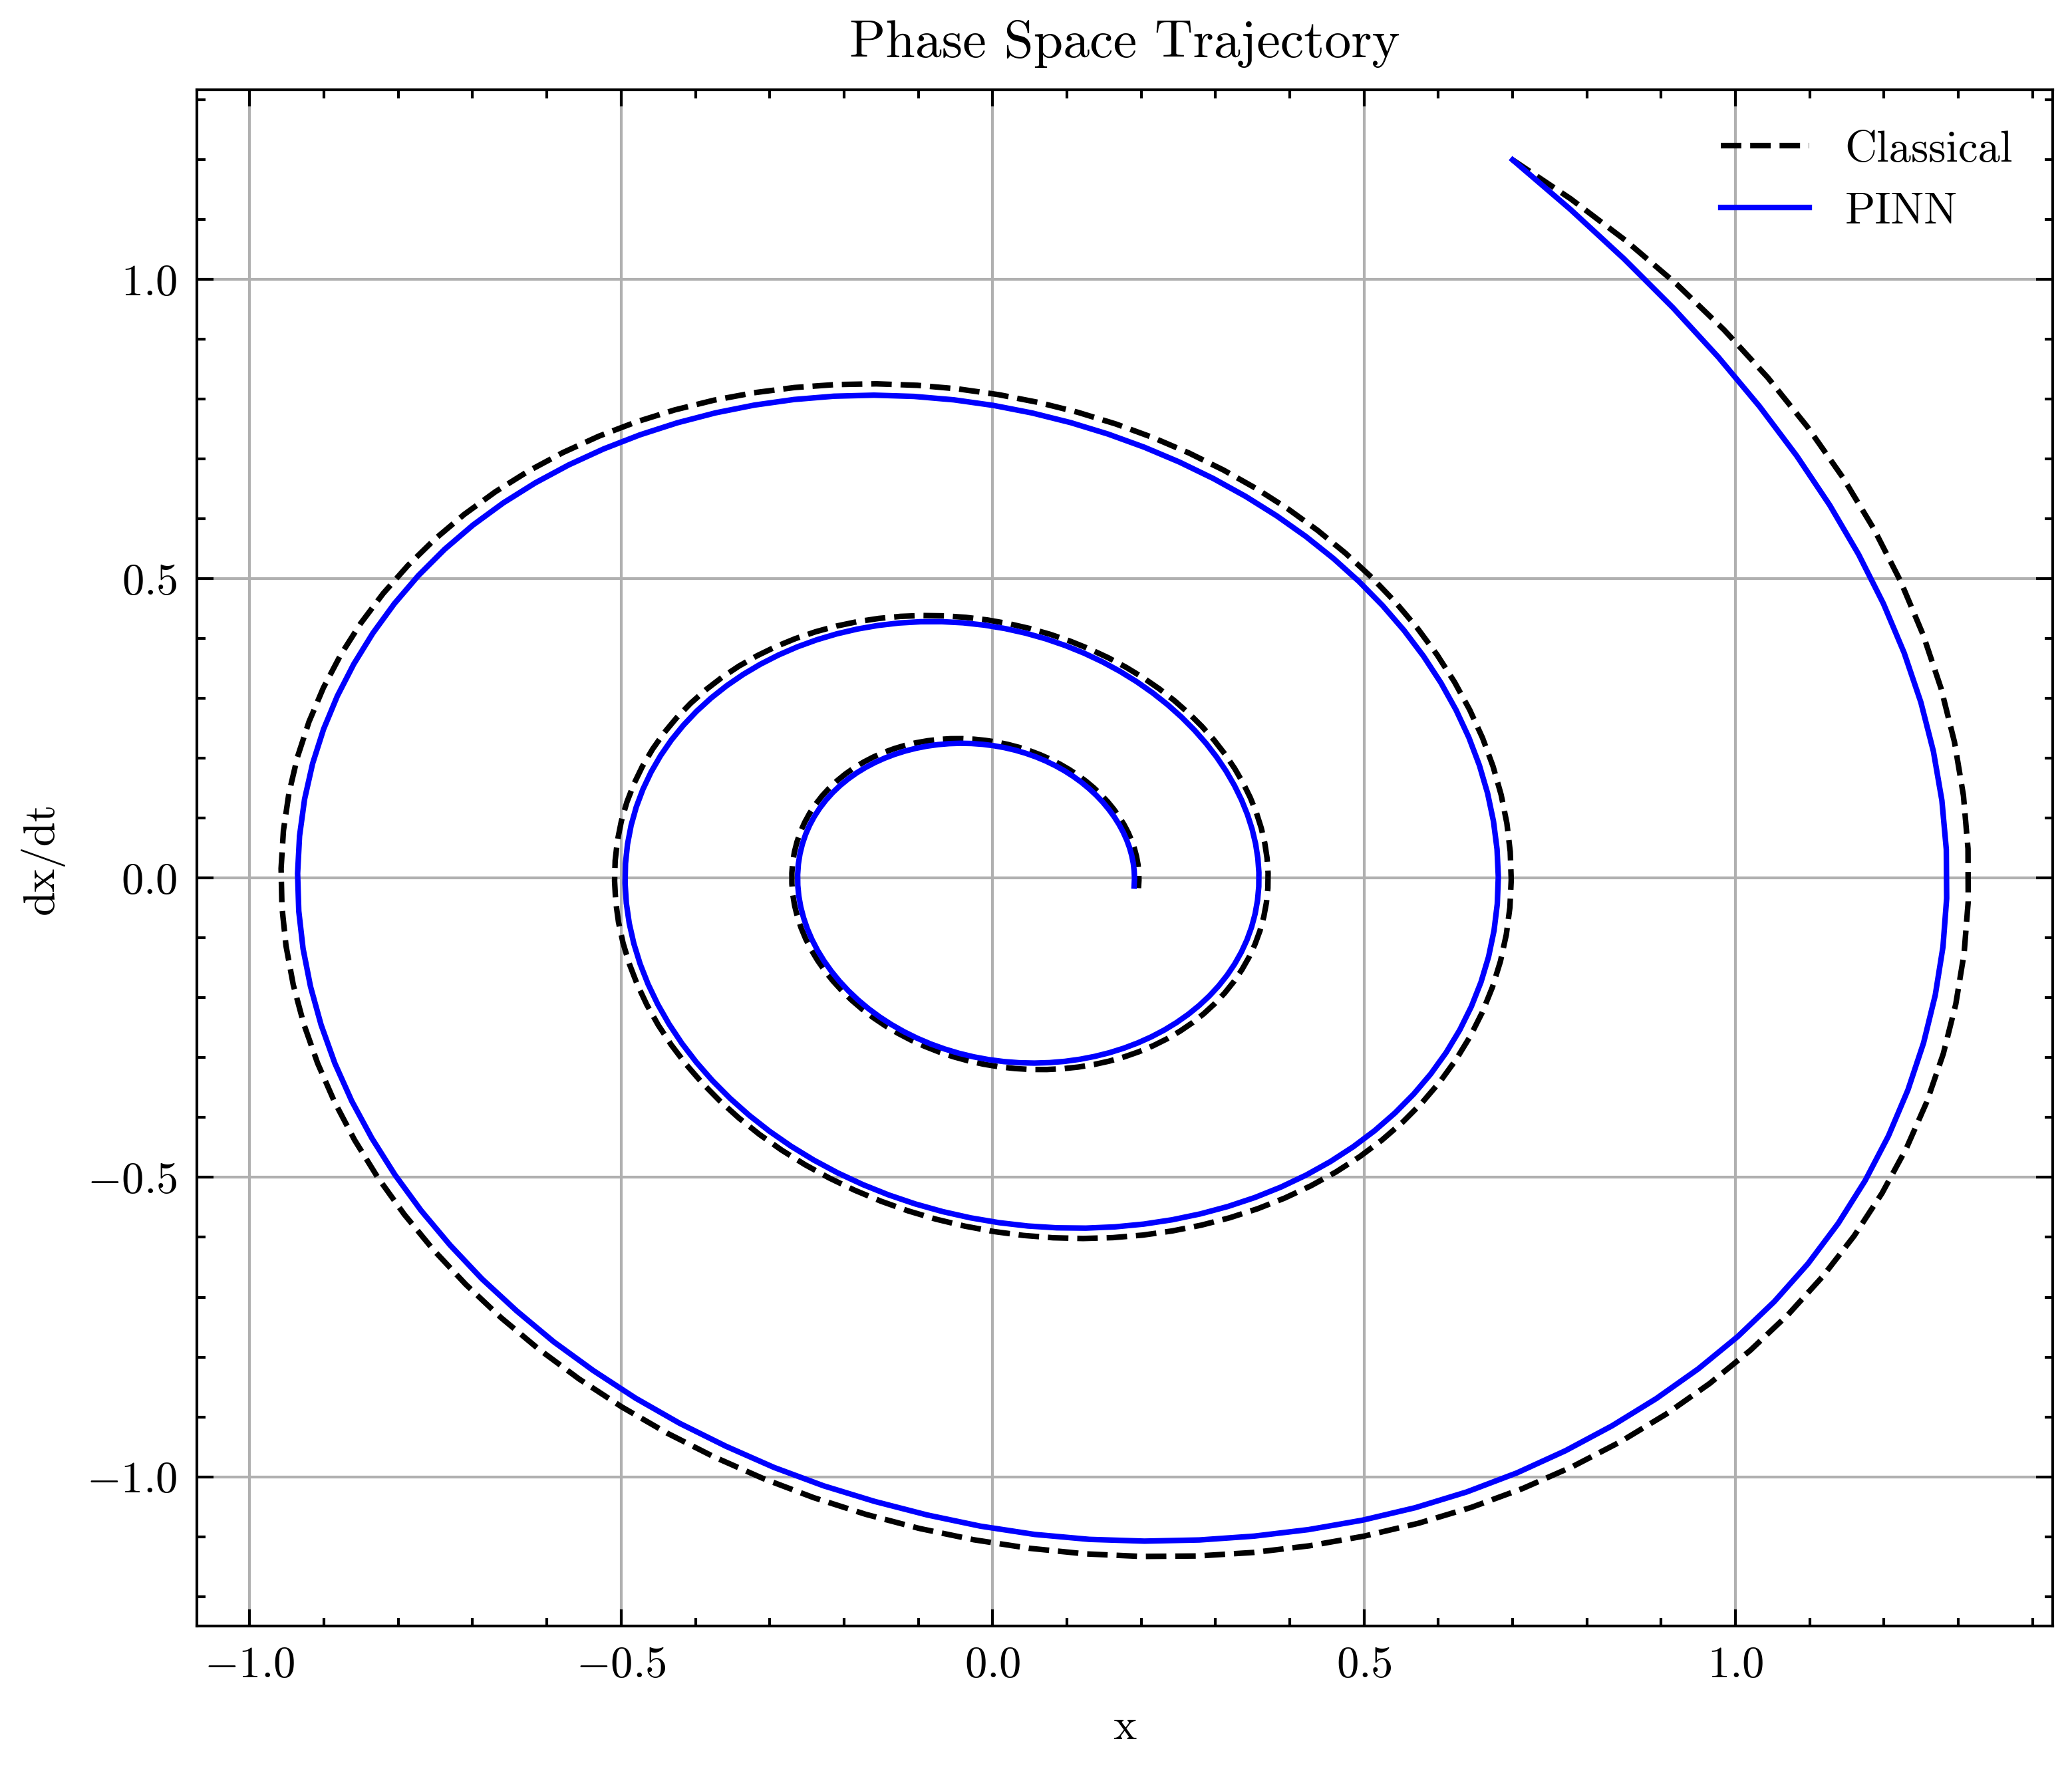

In [7]:
# Calculate dx/dt
t_phase = t_test.clone().detach().requires_grad_(True)
x = model(t_phase)
dx = torch.autograd.grad(x, t_phase, torch.ones_like(x), create_graph=True)[0]

x_np = x.detach().cpu().numpy()
dx_np = dx.detach().cpu().numpy()

# Classical
def classical_deriv(z, y): return [y[1], -2 * xi * y[1] - y[0]]
sol = solve_ivp(classical_deriv, [0, 20], [x0, v0], t_eval=z_test)
x_classical, dx_classical = sol.y

plt.figure(figsize=(6, 5))
plt.plot(x_classical, dx_classical, 'k--', label='Classical')
plt.plot(x_np, dx_np/20, 'b', label='PINN')
plt.xlabel("x")
plt.ylabel("dx/dt")
plt.grid(True)
plt.legend()
plt.title("Phase Space Trajectory")
plt.show()

## 📈 2. **Residual Heatmap** over Time

**Why:** Shows where your model violates the physics most — localized issues are clearly visible.

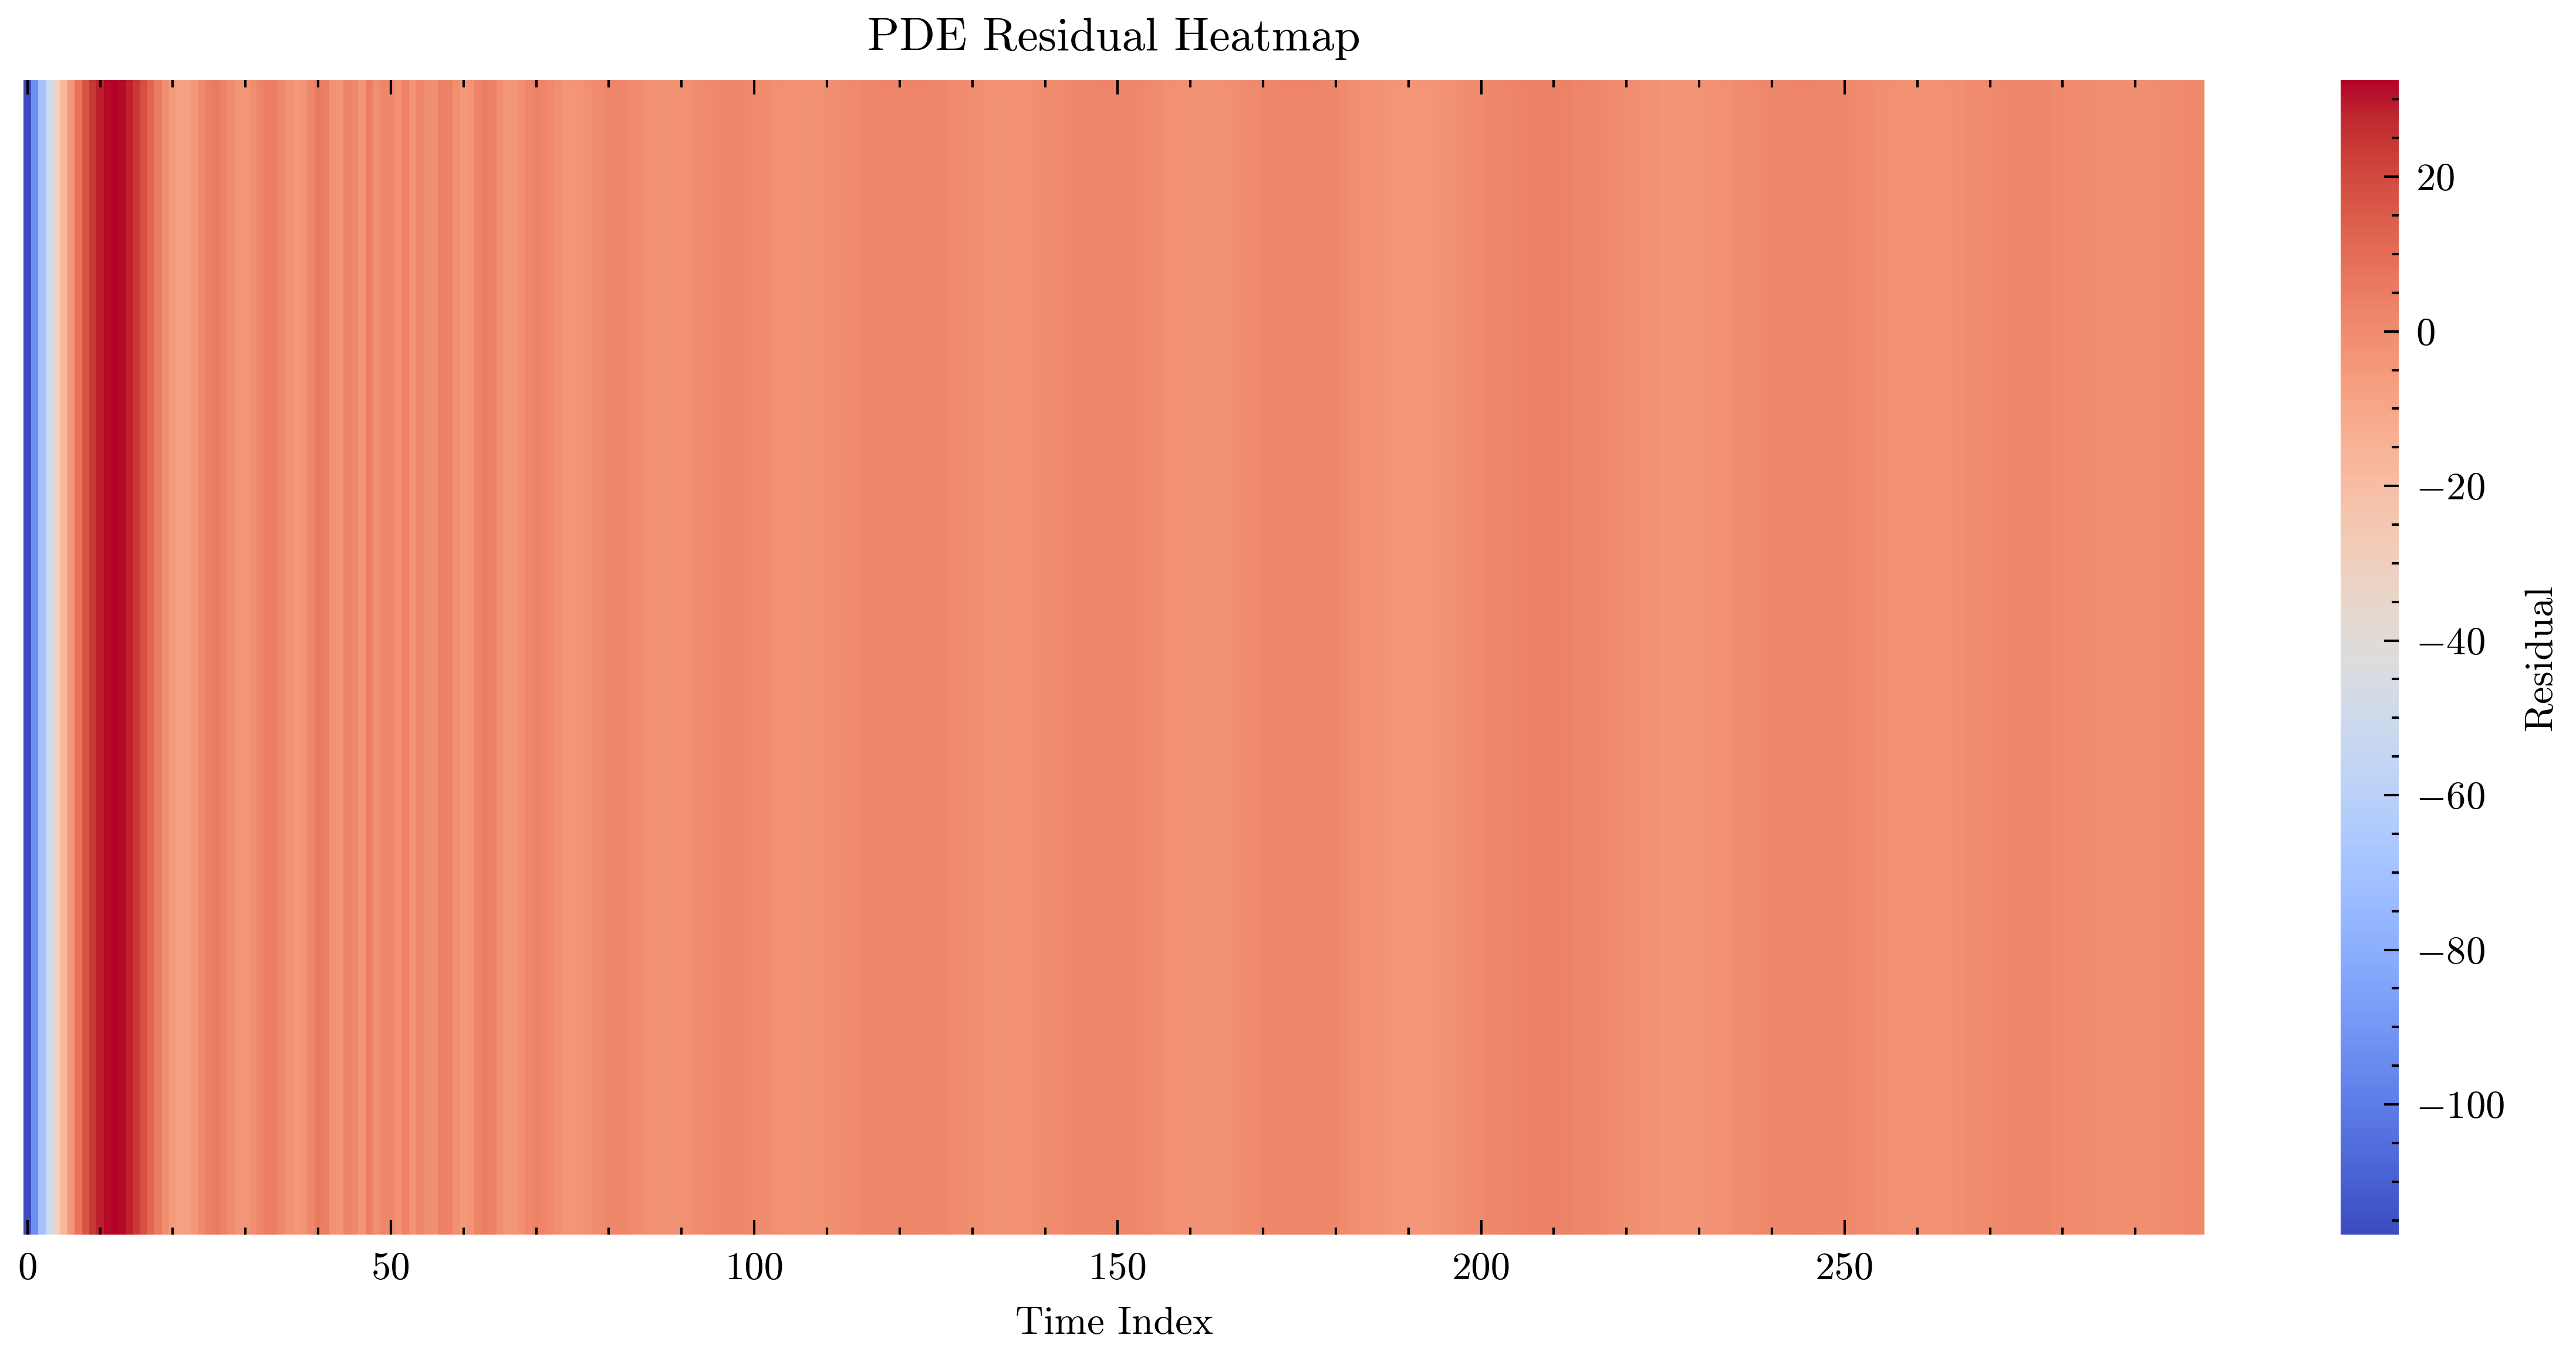

In [8]:
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.heatmap(resid.reshape(1, -1), cmap="coolwarm", xticklabels=50, cbar_kws={'label': 'Residual'})
plt.title("PDE Residual Heatmap")
plt.xlabel("Time Index")
plt.yticks([])
plt.tight_layout()
plt.show()

## 🟠 3. **Error Distribution Histogram**

**Why:** Gives statistical view of errors — useful to see bias, skew, and tails.

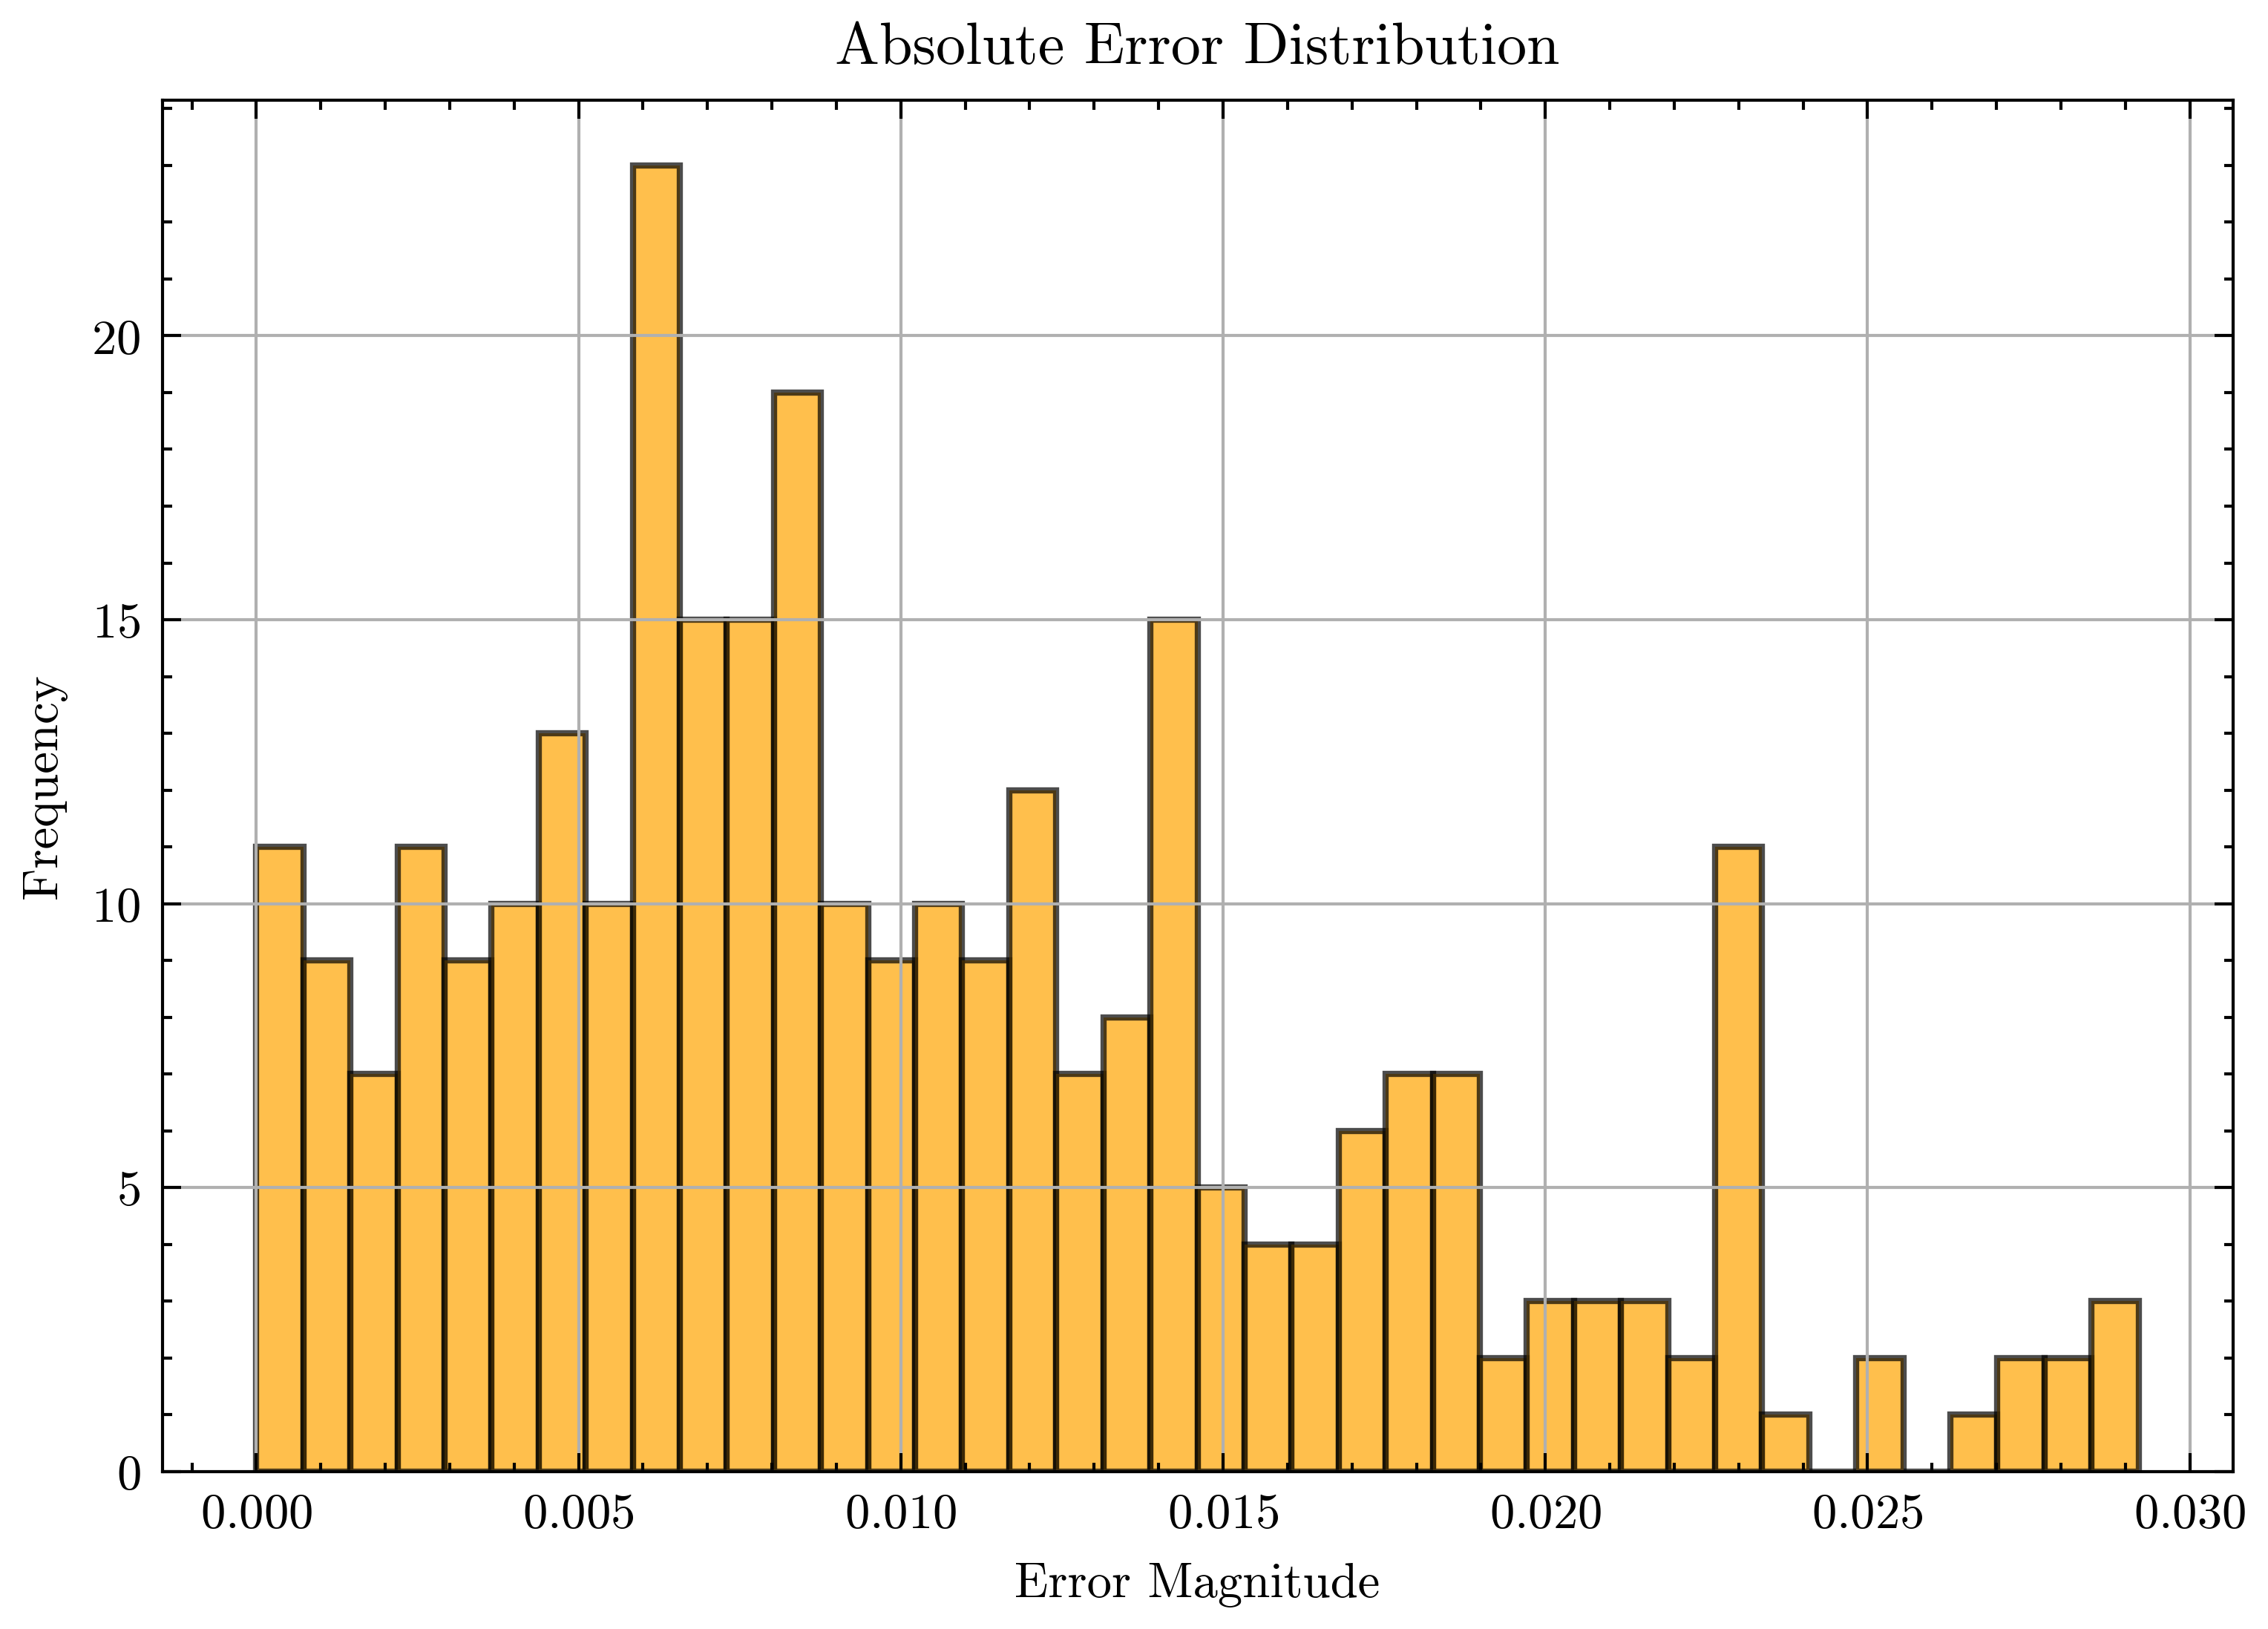

In [9]:
plt.figure(figsize=(6, 4))
plt.hist(abs_error, bins=40, color='orange', edgecolor='k', alpha=0.7)
plt.title("Absolute Error Distribution")
plt.xlabel("Error Magnitude")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()